# Classification using Multiple Classes

Until now, we have only classified using two classes, but there are cases when you will have a multi-classes. In that case a multiclass classification algorithm must be used.

In this example we will predict the species of a penguin. The details were collected by **[Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)**.

In [13]:
import pandas as pd

penguins = pd.read_csv('penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


The dataset has the following columns:
- CulmenLength - The length in mm of the penguin's bill
- CulmenDepth - The depth in mm of the peguins's bill
- FlipperLength - The length in mm of the penguin's flipper
- BodyMass - The mass in grams of the penguin
- Species - An integer denoting the species of the penguin

The species of the penguins are:
- 0 : Adelie
- 1 : Gentoo
- 2 : Chinstrap

In [14]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']

Let's explore any missing data.

In [15]:
penguins.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

There are some missing features, but no missing labels. Let's see which are these records.

In [16]:
penguins[penguins.isnull().any(axis=1)]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
271,NaN,NaN,NaN,NaN,1


As you can see all values are NaN, and these will not be useful when training the model, so we can remove them.

In [18]:
penguins = penguins.dropna()
penguins.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64

The next step is some data exploration, to see how the features relate to the label.

C:\ProgramData\Anaconda3\envs\aci2021\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
C:\ProgramData\Anaconda3\envs\aci2021\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
C:\ProgramData\Anaconda3\envs\aci2021\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray fr

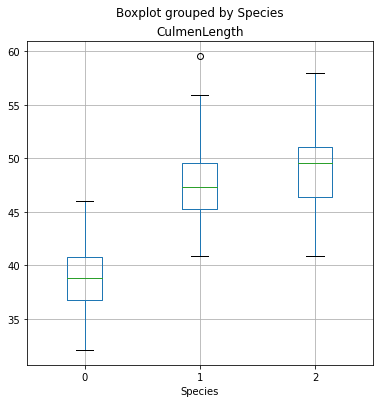

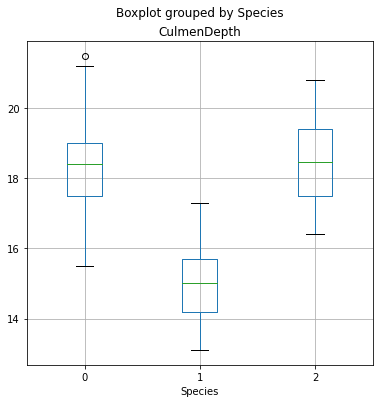

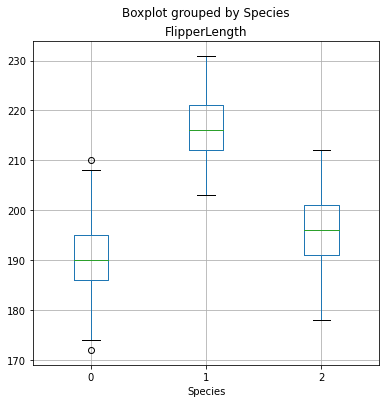

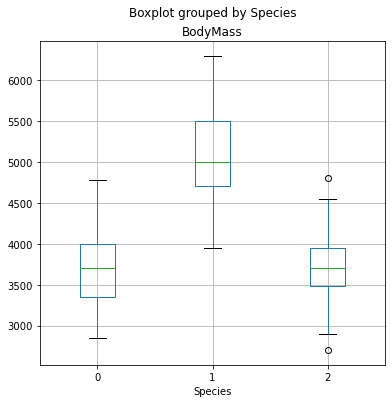

In [20]:
from matplotlib import pyplot as plt

penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'

for col in penguin_features:
    penguins.boxplot(column=col, by=penguin_label, figsize=(6,6))
    plt.title(col)
plt.show()

It looks like species 0 (Adelie) and 2 (Chinstrap) have similar data profiles for all features except culmen length. Species 1 (Gentoo) seem to be different from both the other species.

## Prepare the data

We need to separate the features from the label, and split the data. 

In this case we will also use stratification to maintain a proportion of each label in the training and test sets.

In [21]:
from sklearn.model_selection import train_test_split

penguins_X, penguins_y = penguins[penguin_features].values, penguins[penguin_label].values

x_penguin_train, x_penguin_test, y_penguin_train, y_penguin_test = train_test_split(penguins_X, penguins_y, test_size=0.3, random_state=0, stratify=penguins_y)

print ('Training Set %d\nTest Set %d\n'%(x_penguin_train.shape[0], x_penguin_test.shape[0]))


Training Set 239
Test Set 103



## Train and evaluate a multiclass classifier

In this case once again we will use a LogisticRegression.

In [22]:
from sklearn.linear_model import LogisticRegression

reg = 0.1

multi_model = LogisticRegression(C=1/reg, max_iter=10000).fit(x_penguin_train, y_penguin_train)

print (multi_model)

LogisticRegression(C=10.0, max_iter=10000)


Now we can use the model to predict the labels, and then compare to actual labels.

In [23]:
penguin_predictions = multi_model.predict(x_penguin_test)
print ('Predicted labels: ', penguin_predictions[:10])
print ('Actual labels: ', y_penguin_test[:10])


Predicted labels:  [0 1 0 2 2 1 1 1 0 2]
Actual labels:  [0 1 2 2 2 1 1 1 0 2]


Let's generate a classification report.

In [24]:
from sklearn.metrics import classification_report

print (classification_report(y_penguin_test, penguin_predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



Just like binary classification there is the precision, recall, and F1 Score for each class. However, in this case we cannot focus only on the positive class, but we have to look at the macro or weighted average for a general idea of how well it performed.

Let's prepare a confusion matrix:

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_penguin_test, penguin_predictions)
print (cm)

[[44  0  1]
 [ 0 37  0]
 [ 2  0 19]]


## Showing the ROC Curve

We can also show a ROC Curve for multi class models.

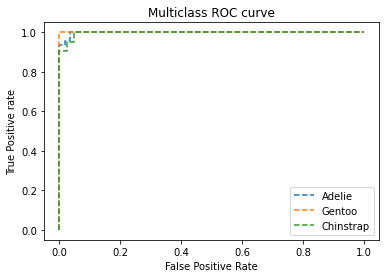

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Get class probability scores
penguin_prob = multi_model.predict_proba(x_penguin_test)

# Get ROC metrics for each class
fpr = {}
tpr = {}
thresh ={}
for i in range(len(penguin_classes)):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_penguin_test, penguin_prob[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i], linestyle='--', label=penguin_classes[i])

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

And we can also calculate the Average area under the curve.

In [27]:
auc = roc_auc_score(y_penguin_test,penguin_prob, multi_class='ovr')
print('Average AUC:', auc)

Average AUC: 0.9981999902100828
